# Lesson 12.3 softmax回归建模实验  

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\HP\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\HP\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\HP\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 一、softmax回归手动实现

&emsp;&emsp;根据此前的介绍，面对分类问题，更为通用的处理办法将其转化为哑变量的形式，然后使用softmax回归进行处理，这种处理方式同样适用于二分类和多分类问题。此处以多分类问题为例，介绍softmax的手动实现形式。

&emsp;&emsp;我们都知道，softmax是用于挑选最大值的一种方法，通过以下公式对不同类的计算结果进行数值上的转化

$$\delta_k = \frac{e^{z_k}}{\sum^Ke^k}$$

这种转化可以将结果放缩到0-1之间，并且使用softmax进行最大值的比较，相比max（softmax是max的柔化版本），能有效避免损失函数求解时在0点不可导的问题，损失函数的函数特性，将是后续我们选择优化算法的关键。具体我们可以通过下述图像进行比较。

Text(0.5, 1.0, 'Max Function')

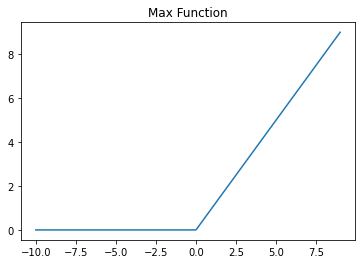

In [2]:
#————————————————————————————max回归的图像表示————————————————————————————

from matplotlib import pyplot

def max_x(x, delta=0.):
    x = np.array(x)
    negative_idx = x < delta
    x[negative_idx] = 0.
    return x
x = np.array(range(-10, 10))
s_j = np.array(x)

hinge_loss = max_x(s_j, delta=1.)

pyplot.plot(s_j, hinge_loss)
pyplot.title("Max Function")

Text(0.5, 1.0, 'softmax vs Max')

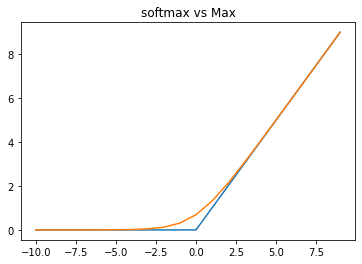

In [3]:
#————————————————————————————max回归与softmax回归的图形对比————————————————————————————
def cross_entropy_test(s_k, s_j):
    soft_max = 1/(1+np.exp(s_k - s_j))
    cross_entropy_loss = -np.log(soft_max)
    return cross_entropy_loss
s_i = 0
s_k = np.array(range(-10, 10))

soft_x = cross_entropy_test(s_k, s_i)

pyplot.plot(x, hinge_loss)
pyplot.plot(range(-10, 10), soft_x)
pyplot.title("softmax vs Max")


# softmax在零点可导

### 1.生成数据集

&emsp;&emsp;利用此前的数据集生成函数，创建一个三分类、且内部离散程度不是很高的分类数据集

In [5]:
tensorGenCla?

Signature:
tensorGenCla(
    num_examples=500,
    num_inputs=2,
    num_class=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
分类数据集创建函数。

:param num_examples: 每个类别的数据数量
:param num_inputs: 数据集特征数量
:param num_class：数据集标签类别总数
:param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
:param bias：建立模型逻辑回归模型时是否带入截距
:return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
File:      g:\python学习资料2022年\codetest\pytorch&深度学习\note_pytorch\note_pytorch\torchlearning.py
Type:      function


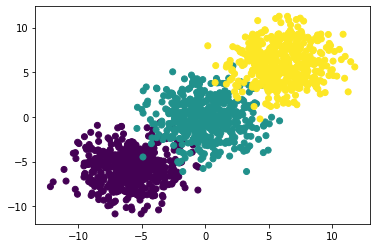

In [6]:
# 设置随机数种子
torch.manual_seed(420)   

# 生成数据
features, labels = tensorGenCla(bias=True, deg_dispersion=[6, 2])
plt.scatter(features[:, 0], features[:, 1], c = labels)

### 2.建模流程

- Stage 1.模型选择

围绕建模目标，我们可以构建一个只包含一层的神经网络进行建模，返回在三个类别上的概率

<img src="https://i.loli.net/2021/02/06/eXSrD9st16FMqpL.jpg" alt="33" style="zoom:30%;" />

输出层的每个神经元输出结果都代表某条样本在三个类别中softmax后的取值，此时神经网络拥有两层，且是全连接。此时从特征到输出结果，就不再是简单的线性方程变换，而是矩阵相乘之后进行softmax转化。

In [7]:
def softmax(X,w):
    m = torch.exp(torch.mm(X,w))
    sp = torch.sum(m,1).reshape(-1,1)
    return m / sp

此处X是特征张量，w是由两层之间的连接权重所组成的矩阵，且w的行数就是输入数据特征的数量，w的列数就是输出层的神经元个数，或者说就是分类问题的类别总数。

计算过程我们可以通过下述例子进行说明：

In [8]:
f = features[: 10]
l = labels[: 10]
f
l

tensor([[-6.0141, -4.9911,  1.0000],
        [-4.6593, -6.7657,  1.0000],
        [-5.9395, -5.2347,  1.0000],
        [-7.0262, -4.5792,  1.0000],
        [-2.3817, -5.1295,  1.0000],
        [-0.7093, -5.4693,  1.0000],
        [-4.1530, -6.8751,  1.0000],
        [-1.9636, -3.3003,  1.0000],
        [-6.5046, -6.0710,  1.0000],
        [-6.1291, -7.1835,  1.0000]])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

In [9]:
w = torch.arange(9).reshape(3, 3).float()
w

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [10]:
m1 = torch.mm(f, w)
m1

# 此时，上述矩阵的每一行都代表每一条数据在三个类别上的线性方程计算结果，
# 然后需要进行softmax转化

tensor([[ -8.9733, -18.9785, -28.9837],
        [-14.2971, -24.7221, -35.1471],
        [ -9.7042, -19.8785, -30.0527],
        [ -7.7375, -18.3429, -28.9483],
        [ -9.3886, -15.8998, -22.4111],
        [-10.4079, -15.5865, -20.7651],
        [-14.6253, -24.6535, -34.6816],
        [ -3.9010,  -8.1649, -12.4289],
        [-12.2130, -23.7886, -35.3642],
        [-15.5506, -27.8632, -40.1758]])

In [11]:
torch.sum(w, 1)

tensor([ 3., 12., 21.])

In [12]:
torch.exp(m1)

tensor([[1.2675e-04, 5.7245e-09, 2.5854e-13],
        [6.1777e-07, 1.8336e-11, 5.4426e-16],
        [6.1026e-05, 2.3275e-09, 8.8770e-14],
        [4.3617e-04, 1.0809e-08, 2.6787e-13],
        [8.3669e-05, 1.2439e-07, 1.8493e-10],
        [3.0193e-05, 1.7016e-07, 9.5900e-10],
        [4.4494e-07, 1.9640e-11, 8.6693e-16],
        [2.0222e-02, 2.8446e-04, 4.0014e-06],
        [4.9654e-06, 4.6637e-11, 4.3803e-16],
        [1.7639e-07, 7.9282e-13, 3.5635e-18]])

In [13]:
torch.sum(torch.exp(m1), 1)          # 计算每一行的exp之后求和

tensor([1.2675e-04, 6.1779e-07, 6.1028e-05, 4.3619e-04, 8.3794e-05, 3.0364e-05,
        4.4495e-07, 2.0511e-02, 4.9655e-06, 1.7639e-07])

In [14]:
torch.exp(m1) / torch.sum(torch.exp(m1), 1).reshape(-1, 1)

tensor([[9.9995e-01, 4.5163e-05, 2.0398e-09],
        [9.9997e-01, 2.9681e-05, 8.8098e-10],
        [9.9996e-01, 3.8138e-05, 1.4546e-09],
        [9.9998e-01, 2.4781e-05, 6.1412e-10],
        [9.9851e-01, 1.4845e-03, 2.2070e-06],
        [9.9436e-01, 5.6040e-03, 3.1583e-05],
        [9.9996e-01, 4.4139e-05, 1.9484e-09],
        [9.8594e-01, 1.3869e-02, 1.9509e-04],
        [9.9999e-01, 9.3923e-06, 8.8216e-11],
        [1.0000e+00, 4.4946e-06, 2.0202e-11]])

上述结果的每一行就是经过sofrmax转化之后每一条数据在三个不同类别上的取值。该函数和nn.functional中softmax函数功能一致。只不过需要注意的是，我们定义的softmax函数需要输入原始数据和系数矩阵，而F.softmax需要输入输出节点中经过线性运算的结果以及softmax的方向（按行还是按列）。

In [15]:
softmax(f,w)

tensor([[9.9995e-01, 4.5163e-05, 2.0398e-09],
        [9.9997e-01, 2.9681e-05, 8.8098e-10],
        [9.9996e-01, 3.8138e-05, 1.4546e-09],
        [9.9998e-01, 2.4781e-05, 6.1412e-10],
        [9.9851e-01, 1.4845e-03, 2.2070e-06],
        [9.9436e-01, 5.6040e-03, 3.1583e-05],
        [9.9996e-01, 4.4139e-05, 1.9484e-09],
        [9.8594e-01, 1.3869e-02, 1.9509e-04],
        [9.9999e-01, 9.3923e-06, 8.8216e-11],
        [1.0000e+00, 4.4946e-06, 2.0202e-11]])

In [16]:
F.softmax(m1, 1)

tensor([[9.9995e-01, 4.5163e-05, 2.0398e-09],
        [9.9997e-01, 2.9681e-05, 8.8098e-10],
        [9.9996e-01, 3.8138e-05, 1.4546e-09],
        [9.9998e-01, 2.4781e-05, 6.1412e-10],
        [9.9851e-01, 1.4845e-03, 2.2069e-06],
        [9.9436e-01, 5.6040e-03, 3.1583e-05],
        [9.9996e-01, 4.4139e-05, 1.9484e-09],
        [9.8594e-01, 1.3869e-02, 1.9509e-04],
        [9.9999e-01, 9.3923e-06, 8.8216e-11],
        [1.0000e+00, 4.4946e-06, 2.0202e-11]])

- Stage 2.确定目标函数

&emsp;&emsp;此时目标函数就是交叉熵损失函数。由于标签已经经过了哑变量转化，因此交叉熵的主体就是每条数据的真实类别对应概率的累乘结果。作为多分类问题的最通用的损失函数，我们有必要简单回顾交叉熵计算过程：

In [17]:
f = torch.tensor([[0.6, 0.2, 0.2], [0.3, 0.4, 0.3]])
l = torch.tensor([0, 1])

f
l

# 其中f代表两条数据在三个类别上通过softmax输出的比例结果，l代表这两条数据的真实标签，

tensor([[0.6000, 0.2000, 0.2000],
        [0.3000, 0.4000, 0.3000]])

tensor([0, 1])

In [19]:
def m_cross_entropy(soft_z, y):
    y = y.long()
    prob_real = torch.gather(soft_z, 1, y)
    return (-(1/y.numel()) * torch.log(prob_real).sum())

> 注意，根据对数运算性质，有$log(x_1x_2)=log(x_1)+log(x_2)$，因此我们可以将交叉熵损失函数中联合概率分布的累乘转化为累加，如果是累乘可以使用以下函数进行计算。

- gather函数的基本用法

In [21]:
l
f

tensor([0, 1])

tensor([[0.6000, 0.2000, 0.2000],
        [0.3000, 0.4000, 0.3000]])

In [20]:
torch.gather(f, 1, l.reshape(-1, 1).long())    
# 1 按照每一行索引
 # 相当于批量索引

tensor([[0.6000],
        [0.4000]])

再在外侧乘以-1/N即可构成哑变量情况下分类问题的交叉熵损失函数的计算结果。

In [22]:
-1 / 2 * (torch.log(torch.tensor(0.6) * torch.tensor(0.4)))

tensor(0.7136)

当然也可以直接使用上述定义的m_cross_entropy函数进行计算

In [23]:
m_cross_entropy(f, l.reshape(-1, 1).long())

# f要是经过softmax转化的结果
# l就在每个类上的概率

tensor(0.7136)

- 使用`nn.CrossEntropyLoss()`完成交叉熵损失函数的计算
  - nn.CrossEntropyLoss()会自动完成softmax过程，
  - 调用该函数时，我们只需要输入线性方程计算结果即可

In [24]:
f = features[: 10]
l = labels[: 10]
w = torch.arange(9).reshape(3, 3).float()
f
l
w

tensor([[-6.0141, -4.9911,  1.0000],
        [-4.6593, -6.7657,  1.0000],
        [-5.9395, -5.2347,  1.0000],
        [-7.0262, -4.5792,  1.0000],
        [-2.3817, -5.1295,  1.0000],
        [-0.7093, -5.4693,  1.0000],
        [-4.1530, -6.8751,  1.0000],
        [-1.9636, -3.3003,  1.0000],
        [-6.5046, -6.0710,  1.0000],
        [-6.1291, -7.1835,  1.0000]])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [ ]:
# 实例化
criterion = nn.CrossEntropyLoss()
criterion(torch.mm(f, w), l.flatten())

# 参数1：线性回归的结果

In [25]:
m_cross_entropy(softmax(f, w), l)

tensor(0.0021)

- Stage 3.定义优化算法

In [27]:
def m_accuracy(soft_z,y):
    acc_bool = torch.argmax(soft_z,1).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    return(acc)

上述函数的soft_z是经过softmax转化之后模型整体输出结果。其中argmax返回最大值的索引值

In [28]:
torch.argmax(torch.tensor([1, 2]))

# 最大值的索引为1

tensor(1)

而对于从0开始进行计数的类别来说，以及softmax函数的输出结果——每一行代表每一条数据在各类别上的softmax取值，我们对softmax的输出结果进行逐行的最大值索引值的计算，即可直接得出每一条数据在当前模型计算结果下所属类别的判别结果。

In [29]:
softmax(f, w)
torch.argmax(softmax(f, w), 1)

# 每一个行中的最大元素都在第0类

tensor([[9.9995e-01, 4.5163e-05, 2.0398e-09],
        [9.9997e-01, 2.9681e-05, 8.8098e-10],
        [9.9996e-01, 3.8138e-05, 1.4546e-09],
        [9.9998e-01, 2.4781e-05, 6.1412e-10],
        [9.9851e-01, 1.4845e-03, 2.2070e-06],
        [9.9436e-01, 5.6040e-03, 3.1583e-05],
        [9.9996e-01, 4.4139e-05, 1.9484e-09],
        [9.8594e-01, 1.3869e-02, 1.9509e-04],
        [9.9999e-01, 9.3923e-06, 8.8216e-11],
        [1.0000e+00, 4.4946e-06, 2.0202e-11]])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
# 梯度调整的函数继续沿用sgd函数

def sgd(params, lr):
    params.data -= lr * params.grad 
    params.grad.zero_()

- Stage.4 训练模型


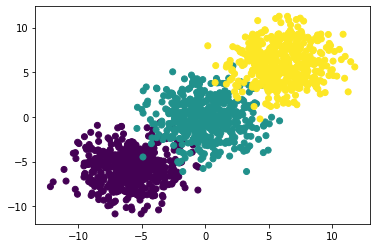

In [31]:
# 设置随机数种子
torch.manual_seed(420)   

# 数值创建
features, labels = tensorGenCla(bias = True, deg_dispersion = [6, 2])
plt.scatter(features[:, 0], features[:, 1], c = labels)

In [32]:
# 设置随机数种子
torch.manual_seed(420)  

# 初始化核心参数
batch_size = 10                                # 每一个小批的数量
lr = 0.03                                      # 学习率
num_epochs = 3                                 # 训练过程遍历几次数据
w = torch.randn(3, 3, requires_grad = True)    # 随机设置初始权重

# 参与训练的模型方程
net = softmax                                     # 使用回归方程
loss = m_cross_entropy                            # 交叉熵损失函数

train_acc = []

# 模型训练过程
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w), y)
        l.backward()
        sgd(w, lr)
    train_acc = m_accuracy(net(features, w), labels)
    print('epoch %d, acc %f' % (epoch + 1, train_acc))

epoch 1, acc 0.824667
epoch 2, acc 0.938667
epoch 3, acc 0.954667


In [33]:
# 查看模型结果
w

tensor([[-0.8224, -0.3235,  0.1638],
        [-0.0686,  0.3762,  0.8428],
        [-0.3366,  1.6309, -0.6424]], requires_grad=True)

- 模型调试

首先，先尝试多迭代几轮，观察模型收敛速度

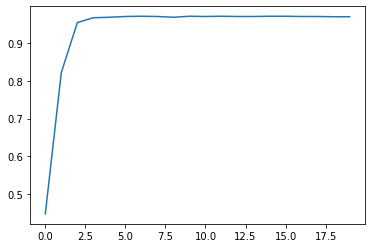

In [35]:
#————————————————————————————多迭代几轮————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 迭代轮数
num_epochs = 20

# 设置初始权重
w = torch.randn(3, 3, requires_grad = True)   

# 设置列表容器
train_acc = []

# 执行迭代
for i in range(num_epochs):
    for epoch in range(i):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, lr)
    train_acc.append(m_accuracy(net(features, w), labels))
    
# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

和此前的逻辑回归实验结果类似，在数据内部离散程度较低的情况下，模型收敛速度较快。

当然，这里我们可以进行简单拓展，那就是当每一轮epoch时w都进行不同的随机取值，会不会影响模型的收敛速度。

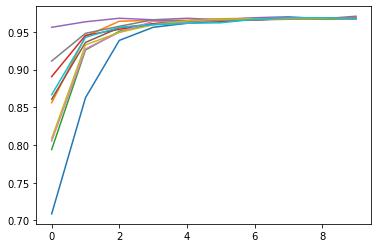

In [36]:
# 取10组不同的w，在迭代10轮的情况下观察其收敛速度

for i in range(10):
    # torch.manual_seed(420) 
    w = torch.randn(3, 3, requires_grad = True)
    train_acc = []
    for epoch in range(10):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, lr)
        train_acc.append(m_accuracy(net(features, w), labels))
    plt.plot(list(range(10)), train_acc)

能够发现，尽管初始w的随机取值会影响前期模型的准确率，但在整体收敛速度较快的情况下，基本在5轮左右模型都能达到较高的准确率。

也就是说，损失函数的初始值点各不相同，但通过一轮轮梯度下降算法的迭代，都能够找到（逼近）最小值点。此处即验证了梯度下降算法本身的有效性，同时也说明对于该数据集来说，找到（逼近）损失函数的最小值点并不困难。

## 二、softmax回归的快速实现

&emsp;&emsp;接下来，尝试通过调库快速sofrmax回归。

1. 定义核心参数和模型
```
class softmaxR(nn.Module):
    def __init__(self,in_features=2,out_features=3,bias=True) -> None:
        super(softmaxR,self).__init__()
        self.linear = nn.Linear(in_features,out_features)

    def forward(self, x):                                    
        out = self.linear(x)             
        return out

# 实例化
softmax_model = softmaxR()
```
2. 定义损失函数 nn.CrossEntropyLoss()
3. 定义优化目标 optim.SGD(softmax_model.parameters(),lr=lr)
4. 训练模型
   ```
   def fit(net, criterion, optimizer, batchdata, epochs):
    for epoch in range(epochs):
        for X, y in batchdata:
            zhat = net.forward(X)
            y = y.flatten().long()       # 损失函数计算要求转化为整数
            loss = criterion(zhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    fit()
   ```

In [37]:
batch_size = 10                                # 每一个小批的数量
lr = 0.03                                      # 学习率
num_epochs = 3                                 # 训练过程遍历几次数据

In [38]:
#————————————————————————————准备数据————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据集
features, labels = tensorGenCla(deg_dispersion = [6, 2])
labels = labels.float()                           # 损失函数要求标签也必须是浮点型
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

In [45]:
#————————————————————————————Stage1 定义模型————————————————————————————
class softmaxR(nn.Module):
    def __init__(self,in_features=2,out_features=3,bias=True) -> None:
        super(softmaxR,self).__init__()
        self.linear = nn.Linear(in_features,out_features)

    def forward(self, x):                                    # 定义模型的正向传播规则
        out = self.linear(x)             
        return out

# 实例化
softmax_model = softmaxR()

> 由于我们所采用的`CrossEntropyLoss`类进行的损失函数求解，该类会自动对输入对象进行softmax转化，因此上述过程仍然只是构建了模型基本架构。

In [46]:
#————————————————————————————Stage2 定义损失函数————————————————————————————
criterion = nn.CrossEntropyLoss()

In [47]:
#————————————————————————————Stage3. 定义优化方法————————————————————————————
optimizer = optim.SGD(softmax_model.parameters(),lr=lr)


In [48]:
#————————————————————————————Stage4.模型训练————————————————————————————
def fit(net, criterion, optimizer, batchdata, epochs):
    for epoch in range(epochs):
        for X, y in batchdata:
            zhat = net.forward(X)
            y = y.flatten().long()       # 损失函数计算要求转化为整数
            loss = criterion(zhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [49]:
fit(net = softmax_model, 
    criterion = criterion, 
    optimizer = optimizer, 
    batchdata = batchData, 
    epochs = num_epochs)

In [50]:
#  训练结果

softmax_model

softmaxR(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [51]:
# 查看模型参数
print(list(softmax_model.parameters()))

# 单独计算截距

[Parameter containing:
tensor([[-0.8463, -0.5115],
        [-0.3023, -0.0237],
        [ 0.1540,  0.4283]], requires_grad=True), Parameter containing:
tensor([-0.9035,  1.5806, -0.3878], requires_grad=True)]


In [52]:
# 计算交叉熵损失
criterion(softmax_model(features), labels.flatten().long())

tensor(0.1779, grad_fn=<NllLossBackward0>)

In [53]:
# 借助F.softmax函数，计算准确率
m_accuracy(F.softmax(softmax_model(features), 1), labels)

tensor(0.9573)

In [54]:
F.softmax(softmax_model(features), 1)

tensor([[9.6163e-01, 3.8337e-02, 3.6071e-05],
        [9.6610e-01, 3.3870e-02, 2.6515e-05],
        [9.6442e-01, 3.5553e-02, 3.1001e-05],
        ...,
        [1.7960e-05, 5.4580e-02, 9.4540e-01],
        [3.3178e-07, 8.0571e-03, 9.9194e-01],
        [1.8604e-04, 1.5292e-01, 8.4689e-01]], grad_fn=<SoftmaxBackward0>)

### 2.模型调试

首先，上述结果能否在多迭代几轮的情况下逐步提升

In [55]:
#————————————————————————————生成数据————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据集
features, labels = tensorGenCla(deg_dispersion = [6, 2])
labels = labels.float()                           # 损失函数要求标签也必须是浮点型
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

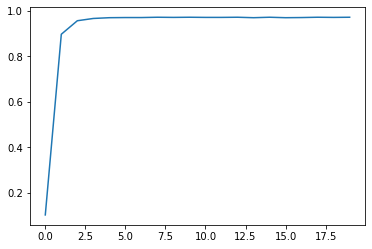

In [56]:
#————————————————————————————多迭代几轮————————————————————————————
# 设置随机数种子
torch.manual_seed(420)  

# 初始化核心参数
num_epochs = 20
SF1 = softmaxR()
cr1 = nn.CrossEntropyLoss()
op1 = optim.SGD(SF1.parameters(), lr = lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net = SF1, 
        criterion = cr1, 
        optimizer = op1, 
        batchdata = batchData, 
        epochs = epochs)
    epoch_acc = m_accuracy(F.softmax(SF1(features), 1), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

和手动实现相同，此处模型也展示了非常快的收敛速度。当然需要再次强调，当num_epochs=20时，SF1参数已经训练了(19+18+...+1)次了。

然后考虑增加数据集分类难度

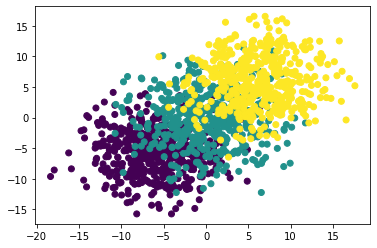

In [58]:
#————————————————————————————增加数据的离散程度————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据集
features, labels = tensorGenCla(deg_dispersion = [6, 4])
labels = labels.float()                           # 损失函数要求标签也必须是浮点型
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

plt.scatter(features[:, 0], features[:, 1], c = labels)

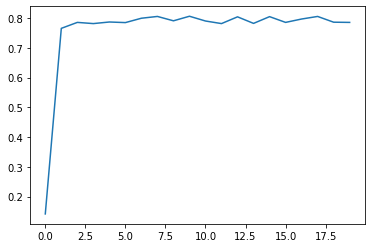

In [59]:
#————————————————————————————增加数据的离散程度————————————————————————————

# 设置随机数种子
torch.manual_seed(420)  

# 初始化核心参数
num_epochs = 20
SF1 = softmaxR()
cr1 = nn.CrossEntropyLoss()
op1 = optim.SGD(SF1.parameters(), lr = lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net = SF1, 
        criterion = cr1, 
        optimizer = op1, 
        batchdata = batchData, 
        epochs = epochs)
    epoch_acc = m_accuracy(F.softmax(SF1(features), 1), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

我们发现，收敛速度仍然很快，模型很快就到达了比较稳定的状态。

但和此前的逻辑回归实验相同，模型结果虽然比较稳定，但受到数据集分类难度提升影响，模型准确率却不高，基本维持在80%左右。

一般来说，此时就代表模型抵达了判别效力上界，此时模型已经无法有效捕捉数据集中规律。

- **模型判别效力上界**   
从根本上来说就是模型已经到达（逼近）损失函数的最小值点，但模型的评估指标却无法继续提升。

首先，我们可以初始选择多个w来观察损失函数是否已经逼近最小值点而不是落在了局部最小值点附近。

In [60]:
#————————————————————————————随机选取多个初始点————————————————————————————
# 初始化核心参数
cr1 = nn.CrossEntropyLoss()

# 创建列表容器
train_acc = []

# 执行建模
# 每次运行建模 初始化都不同的

for i in range(10):
    SF1 = softmaxR()
    op1 = optim.SGD(SF1.parameters(), lr = lr)
    fit(net = SF1, 
        criterion = cr1, 
        optimizer = op1, 
        batchdata = batchData, 
        epochs = 10)
    epoch_acc = m_accuracy(F.softmax(SF1(features), 1), labels)
    train_acc.append(epoch_acc)

In [61]:
train_acc

[tensor(0.7973),
 tensor(0.7960),
 tensor(0.8000),
 tensor(0.7967),
 tensor(0.7913),
 tensor(0.7900),
 tensor(0.7980),
 tensor(0.7900),
 tensor(0.8020),
 tensor(0.8053)]

初始化不同的w发现最终模型准确率仍然是80%左右，也从侧面印证迭代过程没有问题，模型已经到达（逼近）最小值点。